In [1]:
import copy
import warnings
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%config InlineBackend.figure_format='retina'

In [2]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scikitplot.metrics import plot_precision_recall as pr_plot
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
#from catboost import CatBoostClassifier
from sklearn.base import clone
from joblib import dump, load
from io import StringIO
from ipywidgets import Image

In [3]:
def feature_engineering(df):
    """Perform feature engineering:
    a) create binary feature for 99.99 frauds taken in groups;
    b) take log(1+a) of Amount;
    c) perform sine and cosine transformation of "seconds after midnight";
    d) transform "seconds after midnight" to [0,1].
    """
    
    # Amount equal 99.99, transaction concluded in group 
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day  # "seconds after midnight"
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    
    # Transform "seconds after midnight"
    min_max_scaler = MinMaxScaler()
    df["Time"] = min_max_scaler.fit_transform(np.array(df.loc[:, "Time"]).reshape(-1,1))
#     df.drop("Time", axis=1, inplace=True)
    
    return df

In [4]:
def feature_engineering_1(df):
    """Perform feature engineering described in
    EDA_and_baseline_scores notebook. For newer models.
    """
    
    # Amount equal 99.99, transaction concluded in group 
#     df_new = df.sort_values(["Time", "V1"])
#     df_new = df_new[(df_new["Amount"] == 99.99)]
#     df_new["diff"] = df_new["Time"].diff()
#     diff = df_new["diff"]
#     df = df.join(diff)
#     df["Amount_99_group"] = (df["diff"] < 40).astype(int)
#     df.drop("diff", axis=1, inplace=True)

    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
#     df["Time"] = pd.cut(df["Time"], np.arange(-0.5,26.5,3),
#     labels=["0-2","3-5","6-8","9-11","12-14","15-17","18-20","21-23"])
#     df = pd.get_dummies(df, drop_first=True)
#     df.drop(["Time"], inplace=True, axis=1)
    return df

In [5]:
df = pd.read_csv("data\creditcard.csv")
#df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering(df)

In [6]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2019,
                                                    stratify=y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)


In [7]:
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Amount_99_group,Sin_time,Cos_time
208303,0.586333,2.275358,-1.474633,-1.060119,-1.656528,-1.222282,-0.501827,-1.203222,-0.035367,-1.251646,...,0.191971,-0.522123,-0.208686,-0.145667,-0.001611,-0.069176,2.772589,0.0,-0.516160,-0.856492
228887,0.686416,1.942363,-0.926545,-0.739492,-1.593913,-0.789943,-0.422192,-0.713713,0.137006,2.063289,...,0.366779,0.666810,-0.486225,-0.569513,0.011772,-0.036960,3.755837,0.0,-0.921214,-0.389057
284332,0.994803,-1.731651,-0.724775,2.080713,-0.843115,1.542708,0.406017,-0.552330,0.656397,0.588570,...,-0.211272,-1.037862,0.571794,-0.072894,0.057155,0.068047,2.396986,0.0,-0.032792,0.999462
220367,0.645119,1.893223,-2.000045,-0.618185,-1.543741,-1.579722,-0.043760,-1.266857,0.021845,-1.306115,...,0.338354,0.708819,-0.680298,-0.559025,-0.001486,-0.006655,5.238886,0.0,-0.790556,-0.612390
102573,0.790099,-0.989494,1.146768,0.425702,-0.003863,-0.549247,-1.215444,1.100211,-0.137387,-1.032845,...,-0.200352,0.842505,-0.265209,1.048989,-0.245446,-0.045528,4.708178,0.0,-0.968456,0.249183


In [8]:
model = load("xgbclassifier_77_5.joblib")

In [9]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [10]:
y_proba = model.predict_proba(X)
y_pred = (y_proba[:, 1] >= 0.999).astype(int)

ValueError: feature_names mismatch: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Amount_99_group', 'Sin_time', 'Cos_time'] ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Sin_time', 'Cos_time']
expected Amount_99_group in input data

In [137]:
y_pred = model.predict(X)

In [138]:
average_precision_score(y, y_pred)

0.6908800538568212

In [139]:
confusion_matrix(y, y_pred)

array([[284282,     33],
       [   122,    370]], dtype=int64)

In [141]:
np.sum(X[(y_pred==0) & (y==1)]["Amount"])

388.09888

In [144]:
X[(y_pred==0) & (y==1)]["Amount"]

541       0.000000
623       6.272877
4920      5.484507
10204     2.516890
10484     1.566530
            ...   
274382    0.000000
274475    3.711130
275992    6.454097
276071    3.042139
281674    3.773450
Name: Amount, Length: 122, dtype: float32

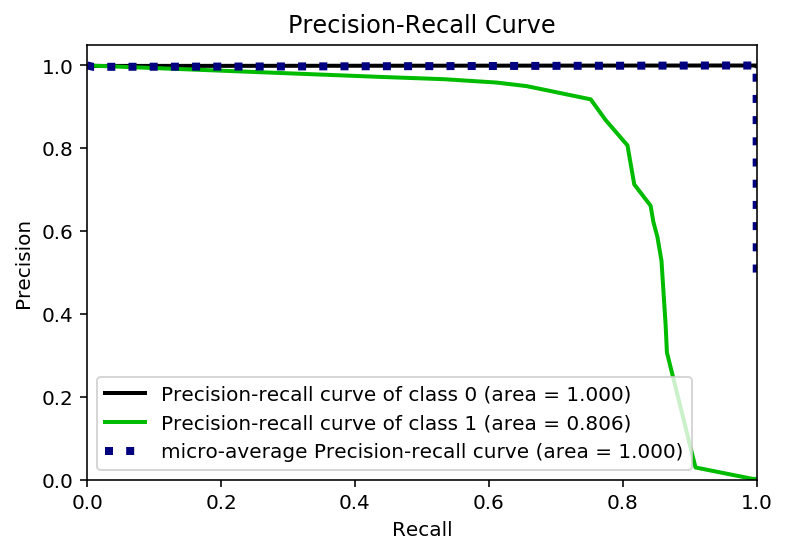

In [105]:
pr_plot(y, y_proba);

In [106]:
def plot_importances(est, columns):
    
    importances = est.feature_importances_
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(columns, importances)
    ax.set_title("{} feature importances".format(type(est).__name__))
    
    return fig

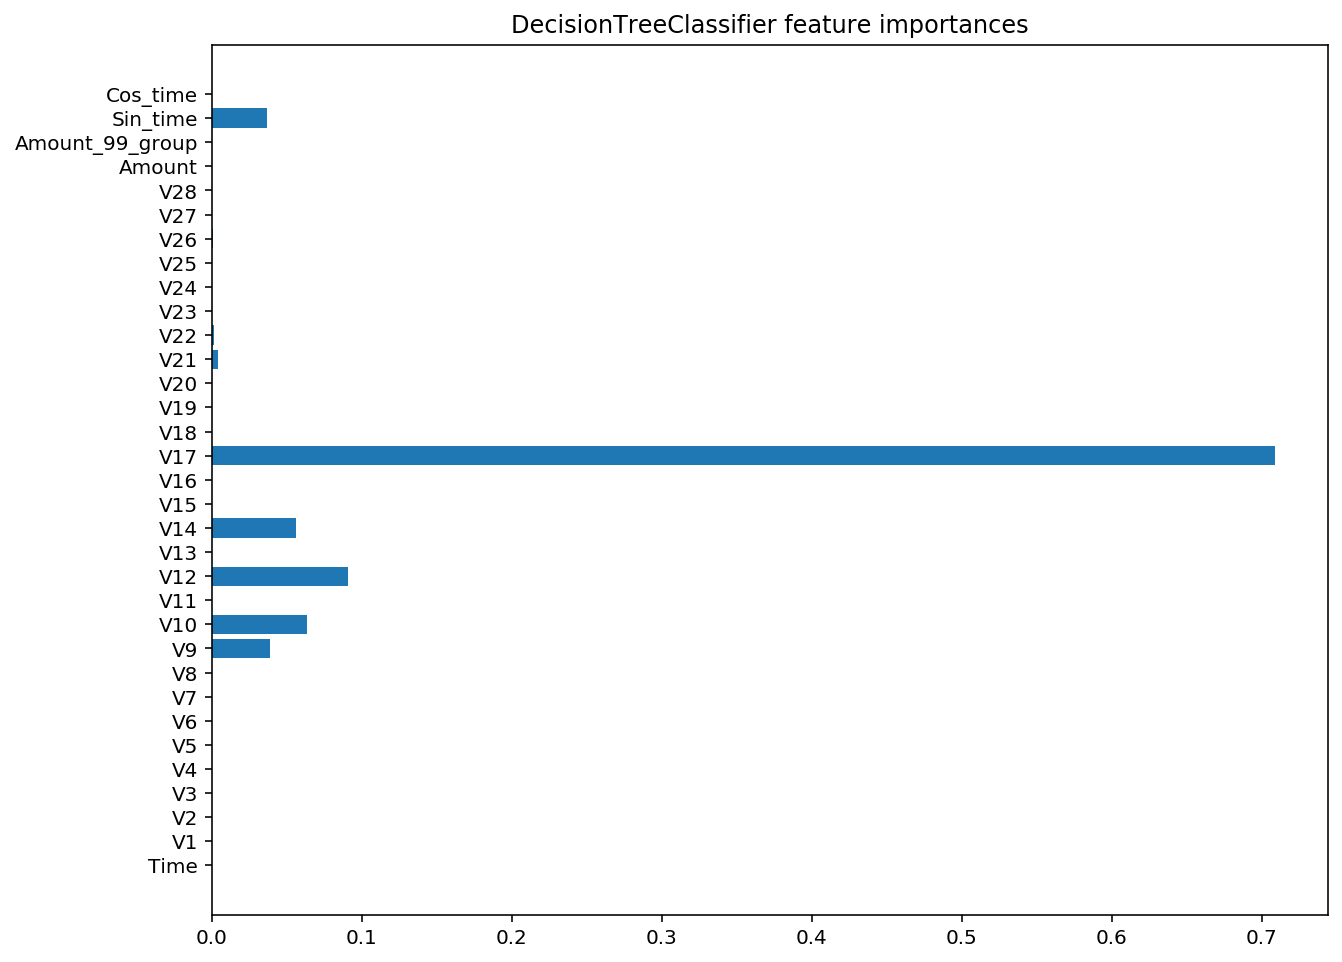

In [107]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

In [72]:
def plot_precision_recall_():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

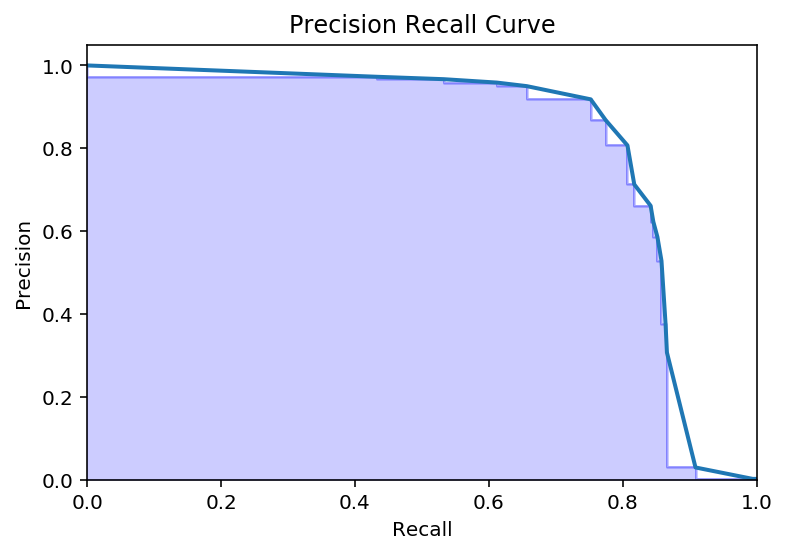

In [35]:
precision, recall, thresholds = precision_recall_curve(y,
                                                       y_proba[:,1])
plot_precision_recall_()

In [148]:
model = load("drzewko_dwa.joblib")

In [149]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2019, splitter='best')

In [161]:
y_proba = model.predict_proba(X)
y_pred = (y_proba[:, 1] >= 0.999).astype(int)

In [162]:
y_pred = model.predict(X)

In [163]:
average_precision_score(y, y_pred)

0.1368169340783023

In [164]:
confusion_matrix(y, y_pred)

array([[281704,   2611],
       [    38,    454]], dtype=int64)

In [155]:
X[(y_pred==0) & (y==1)]["Amount"]

623       6.272877
10484     1.566530
14104     1.415853
18466     0.518794
23422     6.576678
50537     0.693147
55401     0.693147
56703     0.565314
57248     2.149434
58422     5.345106
68633     0.779325
91671     5.673942
95534     3.493777
105178    0.693147
112840    3.829293
118308    3.438493
123238    0.693147
131272    0.182322
142557    5.873047
144754    5.783117
145800    6.114279
149145    2.078191
151196    6.349978
154286    0.652325
176049    7.662407
191074    6.581748
204079    4.696016
213092    3.155723
214775    0.524729
219025    1.702928
231978    2.197225
237426    0.693147
239501    5.473362
248971    0.565314
249239    7.001236
272521    2.588516
274382    0.000000
281674    3.773450
Name: Amount, dtype: float32

In [156]:
np.sum(X[(y_pred==0) & (y==1)]["Amount"])

118.04707

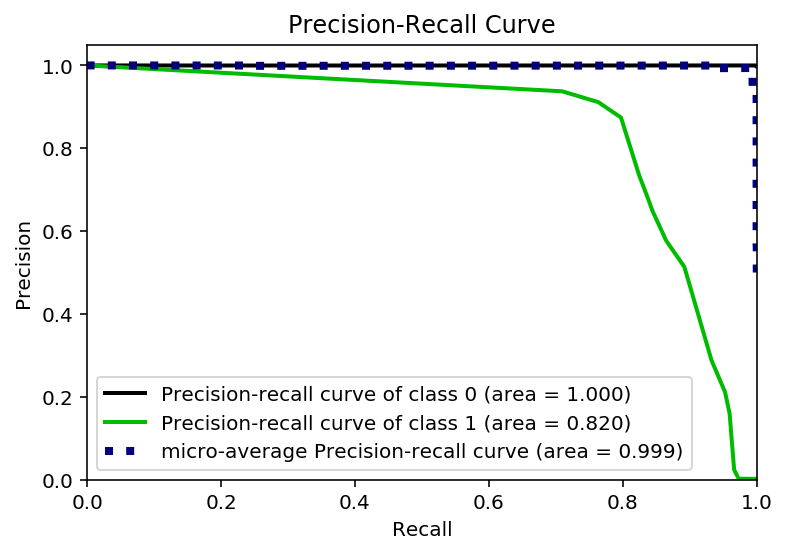

In [126]:
pr_plot(y_test, y_proba);

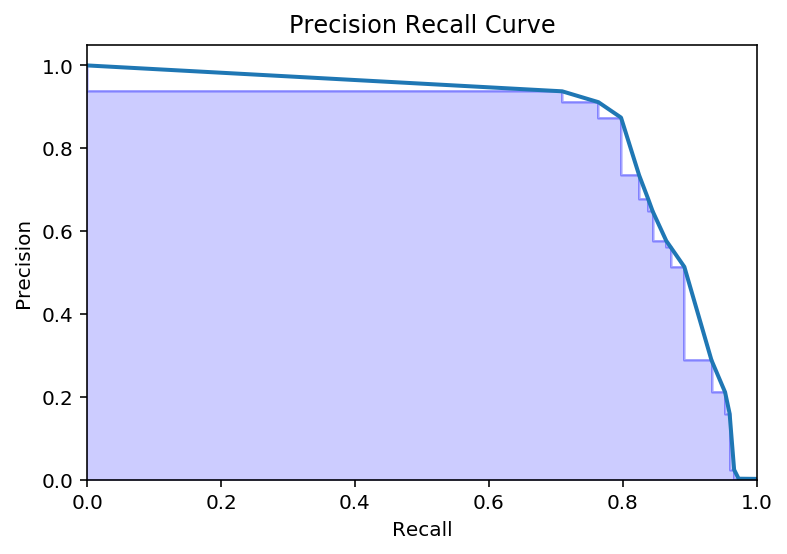

In [128]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       y_proba[:,1])
plot_precision_recall_()

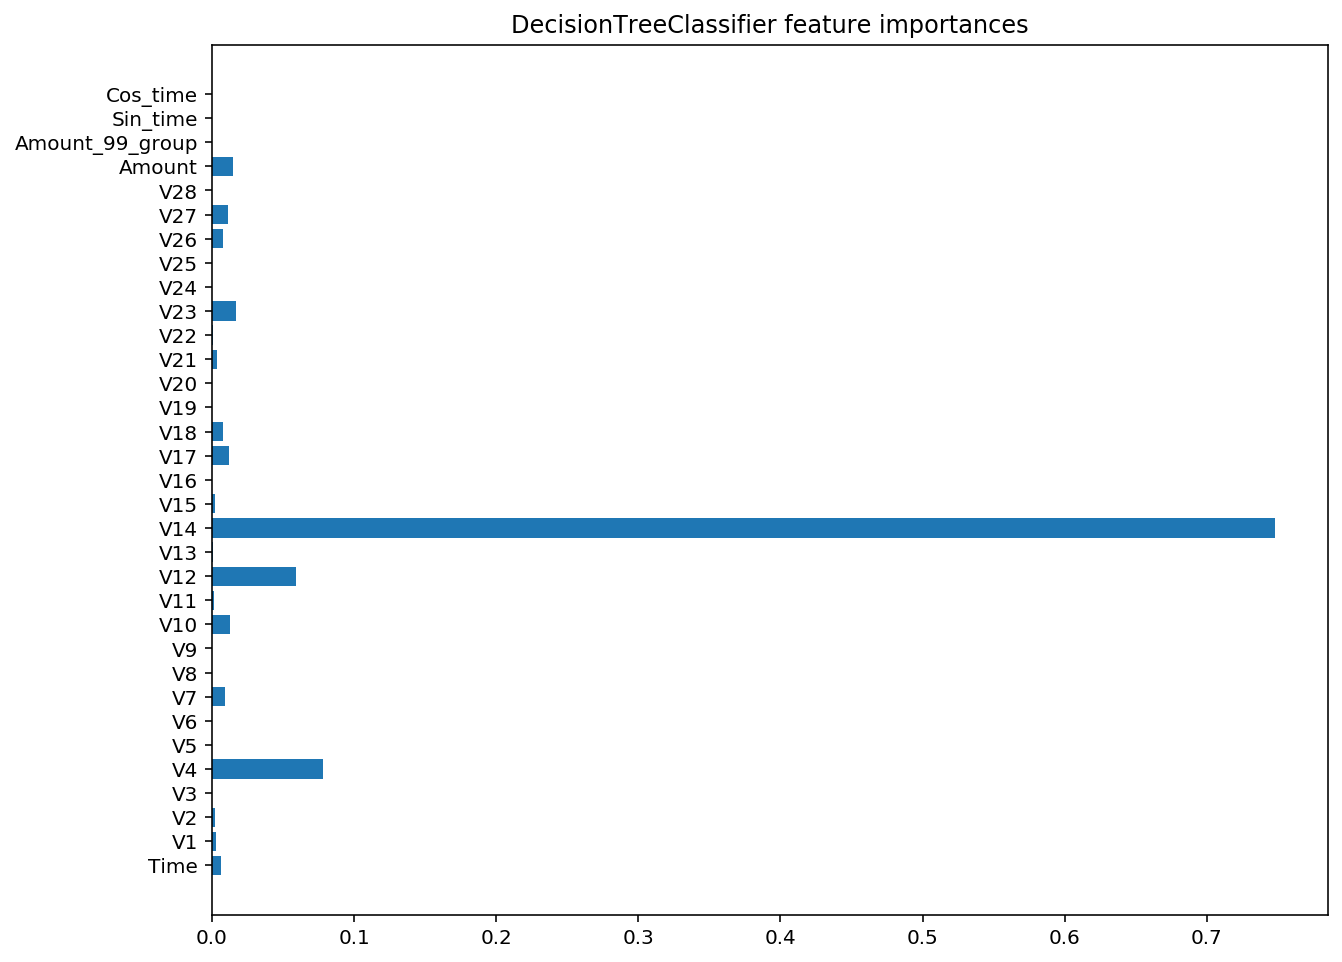

In [129]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

In [94]:
def feature_engineering_2(df):
    
    df["Time"] = (df["Time"]%86400)//3600 #zamiana Time na godzinę w dniu
    df["Time"] = pd.cut(df["Time"],np.arange(-0.5,26.5,3),
                        labels=["0-2","3-5","6-8","9-11","12-14","15-17","18-20","21-23"])
    df = pd.get_dummies(df, drop_first=True)
    df["Amount_0"] = (df["Amount"] == 0).astype(int)
    df["Amount_1"] = (df["Amount"] == 1).astype(int)
    df["Amount_99"] = (df["Amount"] == 99.99).astype(int)
    min_max_scaler = MinMaxScaler()
    df["Amount"] = min_max_scaler.fit_transform(np.array(df.loc[:,"Amount"]).reshape(-1,1))
    return df

In [115]:
X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Amount_99_group', 'Sin_time', 'Cos_time', 'Time_3-5', 'Time_6-8',
       'Time_9-11', 'Time_12-14', 'Time_15-17', 'Time_18-20', 'Time_21-23'],
      dtype='object')

In [8]:
os.chdir(os.getcwd())
df = pd.read_csv("data\data2.csv")
#df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
#df = feature_engineering_2(df)

NameError: name 'os' is not defined

In [133]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2019,
                                                    stratify=y)


In [134]:
model = load("xgbclassifier_1.joblib")

In [156]:
y_proba = model.predict_proba(X)

y_pred = (y_proba[:, 1] >= 0.5).astype(int)

In [157]:
average_precision_score(y, y_pred)

0.8918449396064557

In [158]:
confusion_matrix(y_train, y_pr)

ValueError: Found input variables with inconsistent numbers of samples: [149523, 213605]

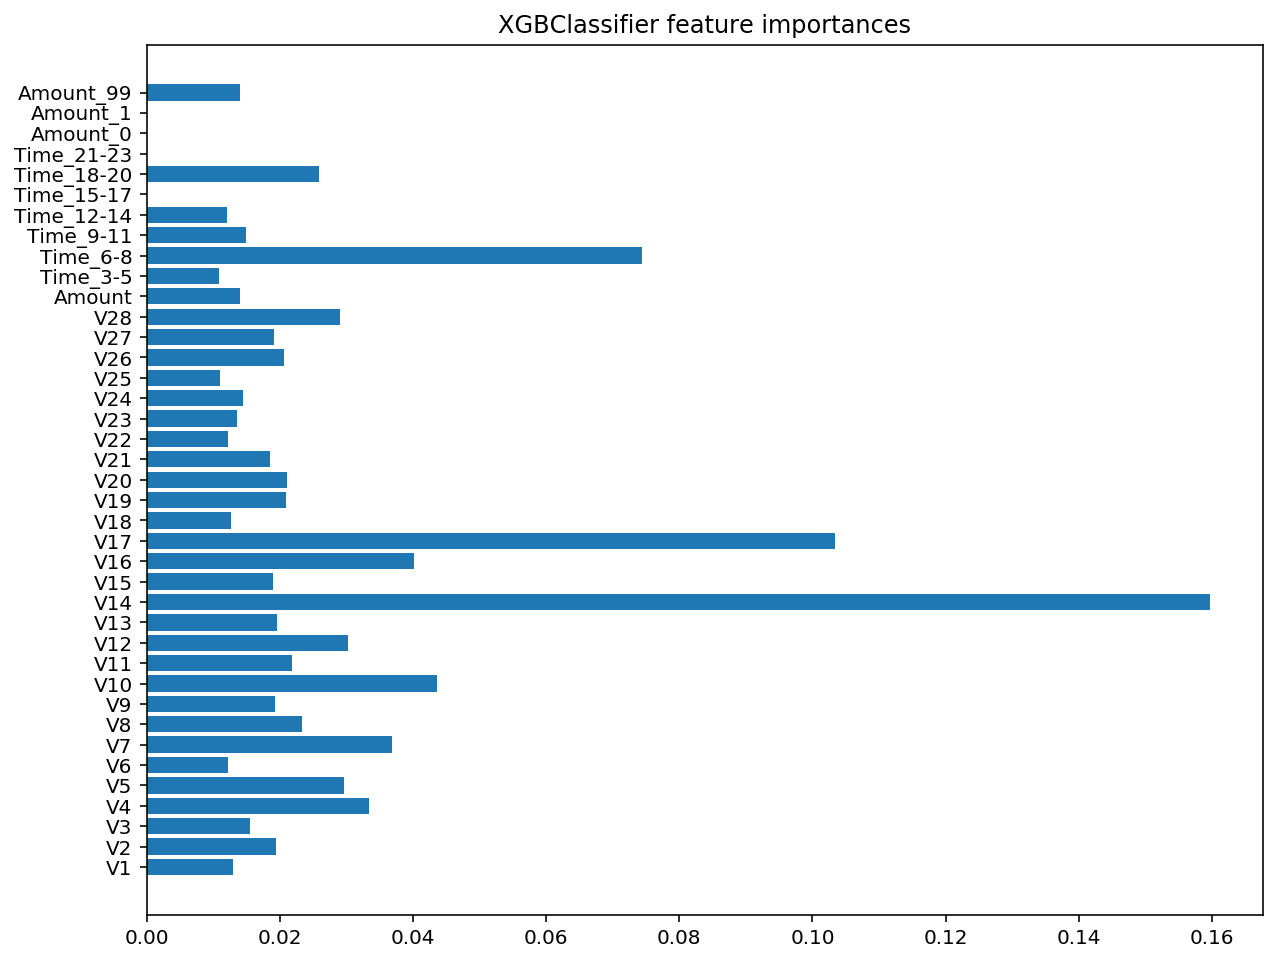

In [149]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

In [151]:
type(model).__name__

'XGBClassifier'

In [140]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       y_proba[:,1])

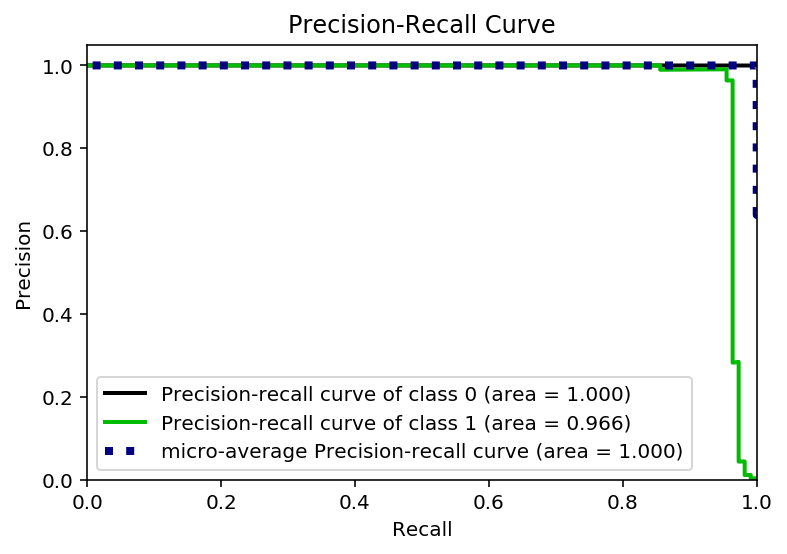

In [144]:
plot_precision_recall(y_test, y_proba)

In [332]:
df = pd.read_csv("data\data.csv")
df = df.sort_values("Time")
df.reset_index(drop=True, inplace=True)

In [333]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213600,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
213601,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
213602,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
213603,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [313]:
df_1 = pd.read_csv("data\creditcard.csv")

In [299]:
df_1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [316]:

df_1[~df_1.isin(df)].dropna()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1.0
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1.0
1122,871.0,0.977232,-0.004728,2.019598,3.049173,-1.073095,0.776208,-0.830617,0.374724,0.579224,...,-0.069751,0.202434,0.072801,0.638221,0.270294,0.028968,0.084372,0.040685,15.17,0.0
1124,872.0,1.001393,-0.521938,-0.163231,0.171474,-0.131066,0.145023,0.047368,0.016985,0.249131,...,-0.181246,-0.790460,-0.226926,-0.801655,0.390593,0.484774,-0.078393,0.014910,158.00,0.0
2356,1902.0,-1.512870,1.311098,0.231925,1.704443,1.889118,4.682058,-0.458256,1.010493,-0.054271,...,0.059697,0.399310,-0.112337,1.032014,-0.050764,0.310193,-0.067102,0.507317,34.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0.0


In [300]:
df_1['key1'] = 1
df['key2'] = 1
df_1 = pd.merge(df_1, df, on=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'], how = 'inner')
df_1 = df_1[~(df_1.key2 == df_1.key1)]
df_1 = df_1.drop(['key1','key2'], axis=1)

In [179]:
df_test.to_csv("data\data_test.csv")

In [187]:
X_test = df_test.drop("Class", axis=1)
y_test = df_test["Class"]

In [188]:
y_test.value_counts()


0.0    71474
1.0      488
Name: Class, dtype: int64

In [424]:
model = load("proba_1.joblib")

In [425]:
y_pred = model.predict(X_test)
average_precision_score(y_test, y_pred)

ValueError: feature_names mismatch: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Amount_99_group', 'Sin_time', 'Cos_time', 'Time_3-5', 'Time_6-8', 'Time_9-11', 'Time_12-14', 'Time_15-17', 'Time_18-20', 'Time_21-23'] ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Amount_99_group', 'Sin_time', 'Cos_time']
expected Time_18-20, Time_3-5, Time_6-8, Time_21-23, Time_15-17, Time_12-14, Time_9-11 in input data

In [348]:
y_proba = model.predict_proba(X_test)

In [347]:
df["Class"].value_counts()

0    213236
1       369
Name: Class, dtype: int64

In [349]:
threshold_scores = dict()
for i in np.arange(0.05,1.01,0.01):

  y_test_threshold = (y_proba[:, 1] >= i).astype(int)
  threshold_scores[i] = average_precision_score(y_test, y_test_threshold)

In [350]:
y_test_threshold

array([0, 0, 0, ..., 0, 0, 0])

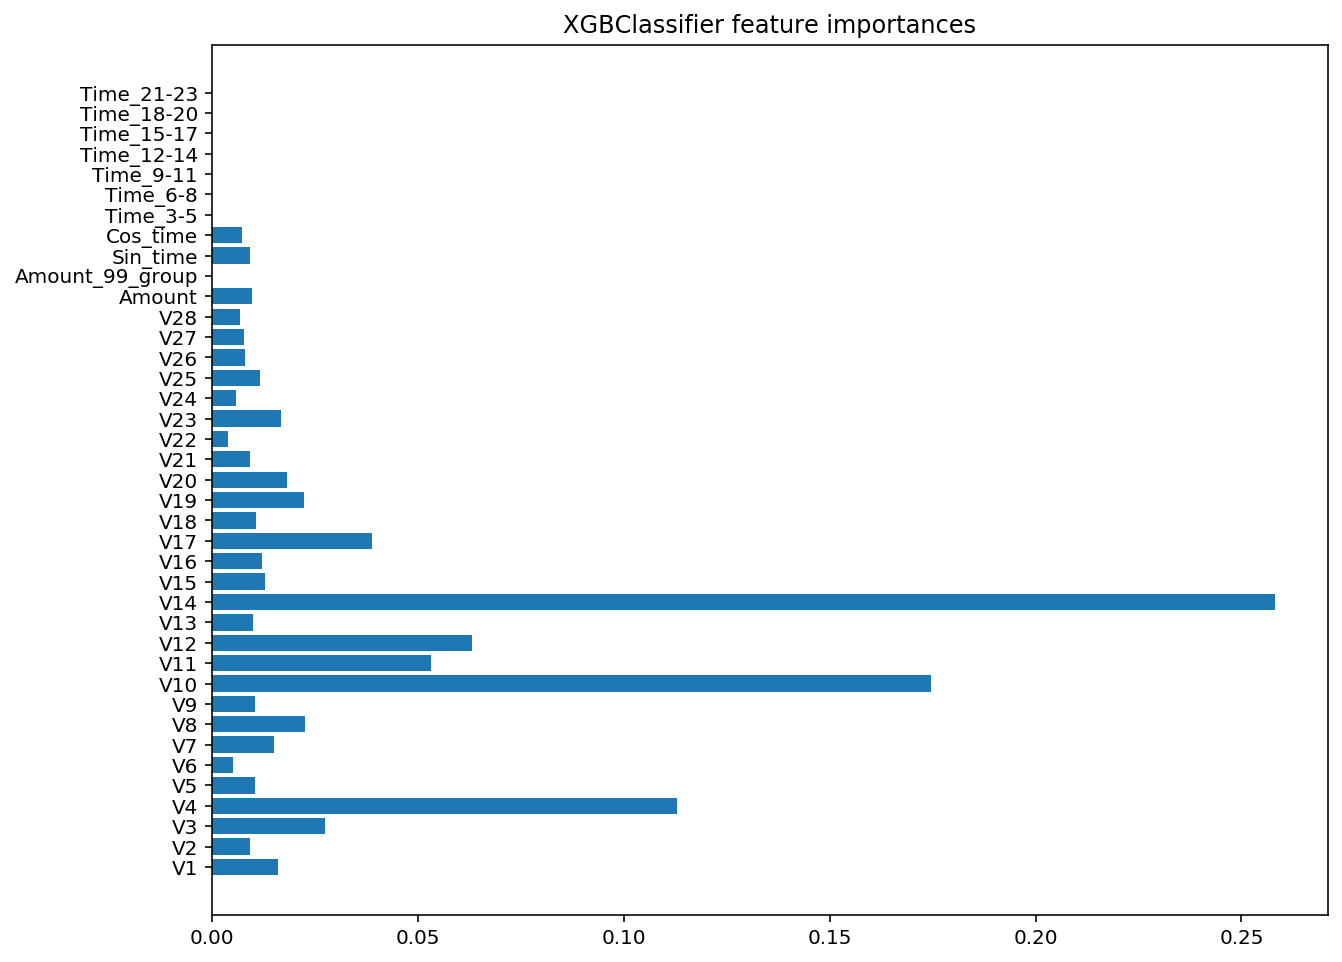

In [353]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

In [9]:
def set_threshold(model, X_test, y_test):
  best_score = 0
  best_thresh = 0
  dic = dict()
  y_proba = model.predict_proba(X_test)
  for threshold in np.arange(0.01, 1, 0.01):
    y_test_threshold = (y_proba[:, 1] >= threshold).astype(int)
    av_prec = average_precision_score(y_test, y_test_threshold)
    dic[threshold] = av_prec
    if av_prec > best_score:
      best_score = av_prec
      best_thresh = threshold
  return best_thresh, best_score, dic